In [1]:
import os
import gc
import parse
import logging
import numpy as np
import pandas as pd

from utils import get_N_tokens, read_and_split_file, raw_dir, interim_dir, final_dir, load_SET_dataset, LABELS

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)

# Generating train dataset and splitting it in train and test

In [2]:
texts, labels = list(), list()

files = ["bswac_tail_pp", "cnrwac_tail_pp_corrected_2", "hrwac_tail_pp", "srwac_tail_pp"]

langs = ["bs", "me", "hr", "sr"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang] * len_cur_texts)

train = pd.DataFrame(data={"text": texts, "labels": labels})


from sklearn.model_selection import train_test_split

train, eval_df = train_test_split(train, test_size=0.1, stratify=train.labels)


In [3]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()


def get_stats(N: int, train=train, eval_df=eval_df, clf=clf):
    import gc
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.metrics import (
        f1_score,
        ConfusionMatrixDisplay,
        confusion_matrix,
        accuracy_score,
    )

    gc.collect()
    vocabulary = get_N_tokens(N)

    def get_coverage(s:str) -> int:
        """Calculates how many vocabulary tokens are in the string.

        Args:
            s (str): input string

        Returns:
            int: number of DISTINCT vocabulary tokens in input string.
        """        
        word_set = set(s.split(" "))
        return len(word_set.intersection(vocabulary))
    vectorizer = CountVectorizer(vocabulary=vocabulary, lowercase=True, binary=True)
    
    eval_df["coverage"] = eval_df.text.apply(get_coverage)
    average_coverage = eval_df.coverage.mean()


    train_vectors = vectorizer.fit_transform(train.text)
    train_labels = train.labels
    test_vectors = vectorizer.fit_transform(eval_df.text)
    y_true = eval_df.labels


    clf.fit(train_vectors.toarray(), train_labels)
    y_pred = clf.predict(test_vectors.toarray())

    LABELS = ["hr", "bs", "sr", "me"]

    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS, average="micro")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    bool_coverage = eval_df.coverage.value_counts()[0]
    returndict = {"N": N, "microF1": micro, "macroF1": macro, "accuracy": acc, "cm": cm,
    "coverage": average_coverage, "clf": clf.__str__(), "bool_coverage": bool_coverage,
    "bool_coverage_ratio": bool_coverage/len(y_true)}
    for lang in LABELS:
        idx = eval_df.labels == lang
        M = idx.sum()
        returndict[f"bool_coverage_ratio_{lang}"] = eval_df.loc[idx, "coverage"].value_counts()[0] / M
    return returndict


In [4]:
Ns = np.logspace(1, 4, 20, dtype=np.int)
results = list()
for N in Ns:
    try:
        logging.info(f"{N=}")
        rezdict = get_stats(N, train=train, eval_df=eval_df, clf=clf)
        rezdict["eval_df"] = "web crawl 10%"
        results.append(rezdict)
    except MemoryError:
        break

2022-01-14 13:34:31,972 - N=10
2022-01-14 13:34:33,731 - NumExpr defaulting to 8 threads.
2022-01-14 13:35:21,171 - N=14
2022-01-14 13:36:10,530 - N=20
2022-01-14 13:36:59,967 - N=29
2022-01-14 13:37:50,419 - N=42
2022-01-14 13:38:40,819 - N=61
2022-01-14 13:39:32,795 - N=88
2022-01-14 13:40:25,831 - N=127
2022-01-14 13:41:20,857 - N=183
2022-01-14 13:42:17,825 - N=263
2022-01-14 13:43:19,136 - N=379
2022-01-14 13:44:25,365 - N=545
2022-01-14 13:45:35,890 - N=784
2022-01-14 13:46:55,041 - N=1128
2022-01-14 13:48:25,511 - N=1623
2022-01-14 13:50:10,108 - N=2335
2022-01-14 13:52:12,630 - N=3359
2022-01-14 13:54:40,778 - N=4832
2022-01-14 13:57:45,314 - N=6951
2022-01-14 14:01:35,387 - N=10000


In [5]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.to_csv("20_results_NB_on_10_percent_of_web_data_extended_with_per_language_coverage.csv")
rezdf

,microF1,macroF1,accuracy,cm,coverage,clf,bool_coverage,bool_coverage_ratio,bool_coverage_ratio_hr,bool_coverage_ratio_bs,bool_coverage_ratio_sr,bool_coverage_ratio_me,eval_df
N,,,,,,,,,,,,,
10,0.362132,0.313213,0.362132,"[[6158, 29, 34, 22], [6503, 333, 557, 171], [3...",0.587948,GaussianNB(),21346,0.643475,0.752843,0.771682,0.649471,0.523803,web crawl 10%
14,0.407832,0.364153,0.407832,"[[6121, 27, 73, 22], [6002, 432, 922, 208], [2...",0.924698,GaussianNB(),17515,0.527990,0.653212,0.659439,0.458617,0.427881,web crawl 10%
20,0.450849,0.407021,0.450849,"[[6093, 38, 85, 27], [5669, 552, 1077, 266], [...",1.274530,GaussianNB(),14610,0.440418,0.570078,0.553808,0.362056,0.351428,web crawl 10%
29,0.483285,0.437404,0.483285,"[[6088, 33, 90, 32], [5395, 635, 1142, 392], [...",1.672324,GaussianNB(),12489,0.376481,0.504245,0.479244,0.308579,0.290109,web crawl 10%
42,0.512616,0.469549,0.512616,"[[6075, 48, 98, 22], [5098, 816, 1219, 431], [...",2.361951,GaussianNB(),9671,0.291532,0.423835,0.375727,0.222789,0.213443,web crawl 10%
61,0.535345,0.488992,0.535345,"[[6093, 47, 86, 17], [4861, 891, 1235, 577], [...",2.979803,GaussianNB(),7852,0.236699,0.368573,0.298519,0.178949,0.166690,web crawl 10%
88,0.564254,0.519657,0.564254,"[[6072, 51, 100, 20], [4526, 1095, 1256, 687],...",3.856208,GaussianNB(),6287,0.189522,0.305462,0.235722,0.157029,0.125480,web crawl 10%
127,0.587616,0.544128,0.587616,"[[6067, 57, 93, 26], [4373, 1268, 1149, 774], ...",4.984716,GaussianNB(),4751,0.143219,0.244274,0.171735,0.123394,0.090522,web crawl 10%
183,0.608175,0.564758,0.608175,"[[6052, 62, 103, 26], [4199, 1386, 1137, 842],...",6.163506,GaussianNB(),3599,0.108492,0.188211,0.129032,0.094482,0.067358,web crawl 10%


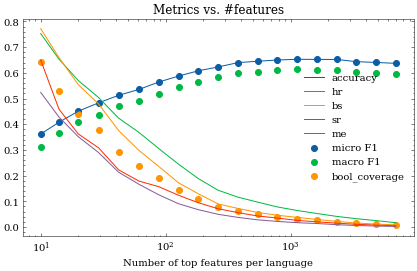

In [8]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.scatter(rezdf.index, rezdf["bool_coverage_ratio"],label="bool_coverage")
plt.xlabel("Number of top features per language")

for lang in LABELS:
    plt.plot(rezdf.index, rezdf[f"bool_coverage_ratio_{lang}"], label=f"{lang}")
plt.legend()
plt.title("Metrics vs. #features")
plt.semilogx()
plt.savefig("images/20_in_domain_coverage_NB_add_per_lang_cov.png")
plt.show()

In [9]:
from sklearn.svm import LinearSVC
clf_lin_svc = LinearSVC(dual=False)
Ns = np.logspace(1, 4, 20, dtype=np.int)
results = list()
for N in Ns:
    try:
        logging.info(f"{N=}")
        rezdict = get_stats(N, train=train, eval_df=eval_df, clf=clf_lin_svc)
        rezdict["eval_df"] = "web crawl 10%"
        results.append(rezdict)
    except MemoryError:
        break

2022-01-14 14:04:15,622 - N=10
2022-01-14 14:05:06,656 - N=14
2022-01-14 14:05:58,714 - N=20
2022-01-14 14:06:51,782 - N=29


KeyboardInterrupt: 

In [ ]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.to_csv("20_results_LinSVC_on_10_percent_of_web_data_extended_with_per_language_coverage.csv")
rezdf

,microF1,macroF1,accuracy,cm,coverage,clf,bool_coverage,bool_coverage_ratio,eval_df
N,,,,,,,,,
10,0.506496,0.358772,0.506496,"[[1227, 156, 30, 4830], [372, 528, 81, 6583], ...",0.577548,LinearSVC(dual=False),21564,0.650047,web crawl 10%
12,0.529648,0.405267,0.529648,"[[1501, 132, 48, 4562], [490, 554, 176, 6344],...",0.703253,LinearSVC(dual=False),20032,0.603865,web crawl 10%
16,0.556808,0.453710,0.556808,"[[1888, 182, 54, 4119], [550, 686, 186, 6142],...",0.990926,LinearSVC(dual=False),16971,0.511591,web crawl 10%
20,0.574684,0.485692,0.574684,"[[1969, 375, 66, 3833], [613, 987, 201, 5763],...",1.256926,LinearSVC(dual=False),14879,0.448527,web crawl 10%
25,0.586350,0.503164,0.586350,"[[2195, 361, 62, 3625], [688, 1043, 207, 5626]...",1.522473,LinearSVC(dual=False),13430,0.404847,web crawl 10%
32,0.601574,0.528829,0.601574,"[[2383, 414, 66, 3380], [723, 1289, 217, 5335]...",1.820517,LinearSVC(dual=False),11917,0.359238,web crawl 10%
41,0.613601,0.548756,0.613601,"[[2491, 476, 76, 3200], [769, 1466, 236, 5093]...",2.247038,LinearSVC(dual=False),10140,0.305670,web crawl 10%
52,0.624815,0.566255,0.624815,"[[2616, 540, 74, 3013], [804, 1645, 246, 4869]...",2.637145,LinearSVC(dual=False),8922,0.268954,web crawl 10%
67,0.637205,0.584853,0.637205,"[[2765, 637, 73, 2768], [836, 1960, 233, 4535]...",3.150213,LinearSVC(dual=False),7574,0.228318,web crawl 10%


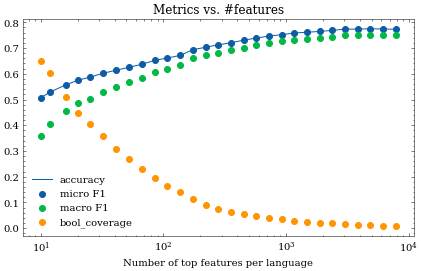

In [26]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.scatter(rezdf.index, rezdf["bool_coverage_ratio"],label="bool_coverage")
plt.legend()
plt.xlabel("Number of top features per language")

plt.title("Metrics vs. #features")
plt.semilogx()
plt.savefig("images/20_in_domain_coverage_LinSVC_add_per_lang_cov.png")
plt.show()